In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#df = pd.read_csv('Data/loan.csv')

df=pd.read_csv('../input/projectdata/loan.csv')

In [4]:


df.info(verbose=True, null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 111 columns):
 #    Column                          Non-Null Count  Dtype  
---   ------                          --------------  -----  
 0    id                              39717 non-null  int64  
 1    member_id                       39717 non-null  int64  
 2    loan_amnt                       39717 non-null  int64  
 3    funded_amnt                     39717 non-null  int64  
 4    funded_amnt_inv                 39717 non-null  float64
 5    term                            39717 non-null  object 
 6    int_rate                        39717 non-null  object 
 7    installment                     39717 non-null  float64
 8    grade                           39717 non-null  object 
 9    sub_grade                       39717 non-null  object 
 10   emp_title                       37258 non-null  object 
 11   emp_length                      38642 non-null  object 
 12   home_ownership  

In [5]:
df.shape

(39717, 111)

In [6]:
# Remove all null columns
df.dropna(axis=1, how='all', inplace=True)
df.shape

(39717, 57)

In [7]:
# Remove columns having only one unique value. This method assumes standard deviation is zero
df.drop(df.std()[(df.std() == 0)].index, axis=1, inplace=True)
df.shape

(39717, 51)

In [8]:
# Remove next_pymnt_d, id, member_id, url, desc, zip_code
df.drop(['next_pymnt_d','id','member_id', 'url', 'desc','zip_code','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt','last_credit_pull_d'], axis=1, inplace=True)

In [9]:
# Clean the percentage columns int_rate and revol_util
def clean_percentages(i):
    i = i.str.replace('%', '')
    i = i.astype('float64')
    return i

In [10]:
df['int_rate'] = clean_percentages(df['int_rate'])
df['revol_util'] = clean_percentages(df['revol_util'])

In [11]:
# Use the average to fill the nan values
df['revol_util'] = df['revol_util'].fillna(df['revol_util'].mean())
# should we use mode instead?

In [12]:
# Replace nan values with mode
df['pub_rec_bankruptcies'].value_counts(dropna=False)

0.0    37339
1.0     1674
NaN      697
2.0        7
Name: pub_rec_bankruptcies, dtype: int64

In [13]:
df.groupby('pub_rec_bankruptcies', dropna=False).mean()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,recoveries,collection_recovery_fee
pub_rec_bankruptcies,,,,,,,,,,,,,,,,,,,
0.0,11301.622298,11027.154584,10606.266580,11.980606,326.132241,69186.729521,13.351199,0.145264,0.862851,36.963931,55.036145,9.287099,0.012802,13544.142264,48.594089,22.167707,53.126521,95.700599,12.372995
1.0,9905.704898,9634.886499,9080.053971,13.484570,290.273202,63837.143590,13.543076,0.153524,0.953405,39.553655,101.264636,9.411589,1.000000,9671.612306,56.900599,21.529869,26.331511,80.438190,8.659830
2.0,12800.000000,12453.571429,12303.834876,15.971429,373.270000,77100.000000,13.010000,0.142857,0.428571,39.000000,99.428571,9.857143,2.000000,10863.857143,75.385714,18.428571,978.267143,18.918571,0.189186
NaN,9956.420373,9829.878049,2355.741259,10.640230,322.301119,69544.443271,10.838465,0.196557,1.011478,12.955137,1.631884,9.398852,0.030129,13662.573888,41.940603,19.242468,0.000000,105.834471,23.300418


In [14]:
df['pub_rec_bankruptcies'].fillna(df['pub_rec_bankruptcies'].mode()[0], inplace=True)

In [15]:
# We'll consider 0-1 as 0 years, 10+ as 10 years
df['emp_length'].value_counts(dropna=False)

10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
NaN          1075
Name: emp_length, dtype: int64

In [16]:
# Function to clean emp_length
def clean_emp(i):
    i = i.str.replace('< 1 year','0')
    i = i.fillna('0')
    i = i.str.replace(' ','')
    i = i.str.replace('years','')
    i = i.str.replace('year','')
    i = i.str.replace('+','')
    i = i.astype('int64')
    return i

In [17]:
df['emp_length'] = clean_emp(df['emp_length'])

In [18]:
df['emp_length'].value_counts()

10    8879
0     5658
2     4388
3     4095
4     3436
5     3282
1     3240
6     2229
7     1773
8     1479
9     1258
Name: emp_length, dtype: int64

In [19]:
# Remove this column as most of the values are missing
df['mths_since_last_delinq'].value_counts(dropna=False)

NaN      25682
0.0        443
15.0       252
30.0       247
23.0       247
         ...  
89.0         1
107.0        1
85.0         1
97.0         1
95.0         1
Name: mths_since_last_delinq, Length: 96, dtype: int64

In [20]:
df.drop('mths_since_last_delinq', axis=1, inplace=True)

In [21]:
# Change nan values to other
df['emp_title'].value_counts(dropna=False)

NaN                                2459
US Army                             134
Bank of America                     109
IBM                                  66
AT&T                                 59
                                   ... 
AMEC                                  1
lee county sheriff                    1
Bacon County Board of Education       1
Hotpads                               1
Evergreen Center                      1
Name: emp_title, Length: 28821, dtype: int64

In [22]:
df['emp_title'].fillna('Other', inplace=True)

In [23]:
# There are too many unique values, also Title might not be really helpful in analysis
df['title'].value_counts()

Debt Consolidation                  2184
Debt Consolidation Loan             1729
Personal Loan                        659
Consolidation                        517
debt consolidation                   505
                                    ... 
your rate is better than my rate       1
Concession Trailer                     1
gregs                                  1
EZover                                 1
JAL Loan                               1
Name: title, Length: 19615, dtype: int64

In [24]:
# Dropping Title as title cannot be used in Analysis
df.drop(columns=['title'],inplace=True)

In [25]:
# Remove ' months' and convert into year
df['term'].value_counts()

 36 months    29096
 60 months    10621
Name: term, dtype: int64

In [26]:
# Function to clean the term column
def clean_term(i):
    i = i.str.replace(' months','').astype('int64')
    i = i/12
    i = i.astype('int64')
    return i

In [27]:
df['term'] = clean_term(df['term'])

In [28]:
# Remove mths_since_last_record since most of the values are missing
df.drop('mths_since_last_record', axis=1, inplace=True)

In [29]:
# Function to clean date objects
def clean_date(i):
    i = i.str.replace('-', ' ')
    i = i.str[:4]+'20'+i.str[4:]
    i = pd.to_datetime(i).dt.to_period('M')
    return(i)

In [30]:
# Change issue_d to datetime

# Now using string split to separate months and year

m, y = df['issue_d'].str.split('-').str

df['issue_y'] = pd.to_numeric(y)
df['issue_m'] = m
df.drop(columns=['issue_d'], inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  int64  
 4   int_rate                 39717 non-null  float64
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_title                39717 non-null  object 
 9   emp_length               39717 non-null  int64  
 10  home_ownership           39717 non-null  object 
 11  annual_inc               39717 non-null  float64
 12  verification_status      39717 non-null  object 
 13  loan_status              39717 non-null  object 
 14  pymnt_plan            

In [32]:
df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,recoveries,collection_recovery_fee,pub_rec_bankruptcies,issue_y
count,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,...,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000
mean,11219.443815,10947.713196,10397.448868,3.534834,12.021177,324.561922,4.838835,6.896893e+04,13.315130,0.146512,...,9.294408,0.055065,13382.528086,48.832152,22.088828,51.227887,95.221624,12.406112,0.042501,10.328902
std,7456.670694,7187.238670,7128.450439,0.885235,3.724825,208.874874,3.605528,6.379377e+04,6.678594,0.491812,...,4.400282,0.237200,15885.016641,28.314793,11.401709,375.172839,688.744771,148.671593,0.202603,0.877514
min,500.000000,500.000000,0.000000,3.000000,5.420000,15.690000,0.000000,4.000000e+03,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,5500.000000,5400.000000,5000.000000,3.000000,9.250000,167.020000,2.000000,4.040400e+04,8.170000,0.000000,...,6.000000,0.000000,3703.000000,25.500000,13.000000,0.000000,0.000000,0.000000,0.000000,10.000000
50%,10000.000000,9600.000000,8975.000000,3.000000,11.860000,280.220000,4.000000,5.900000e+04,13.400000,0.000000,...,9.000000,0.000000,8850.000000,49.200000,20.000000,0.000000,0.000000,0.000000,0.000000,11.000000
75%,15000.000000,15000.000000,14400.000000,5.000000,14.590000,430.780000,9.000000,8.230000e+04,18.600000,0.000000,...,12.000000,0.000000,17058.000000,72.300000,29.000000,0.000000,0.000000,0.000000,0.000000,11.000000
max,35000.000000,35000.000000,35000.000000,5.000000,24.590000,1305.190000,10.000000,6.000000e+06,29.990000,11.000000,...,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,29623.350000,7002.190000,2.000000,11.000000


#### Removing Outliers

0    19300
1    10971
2     5812
3     3048
4      326
5      146
6       64
7       35
8       15
Name: inq_last_6mths, dtype: int64

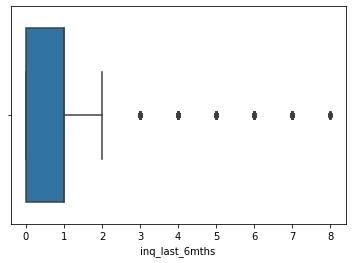

In [33]:
sns.boxplot(df.inq_last_6mths)
df.inq_last_6mths.value_counts()

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='annual_inc'>

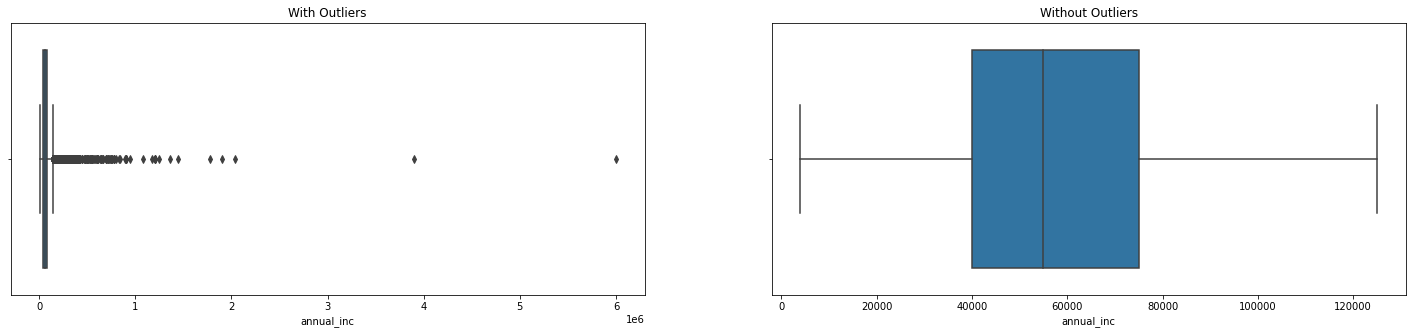

In [34]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.annual_inc,ax=axes[0])
sns.boxplot(df[df.annual_inc<125000].annual_inc,ax=axes[1])

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='loan_amnt'>

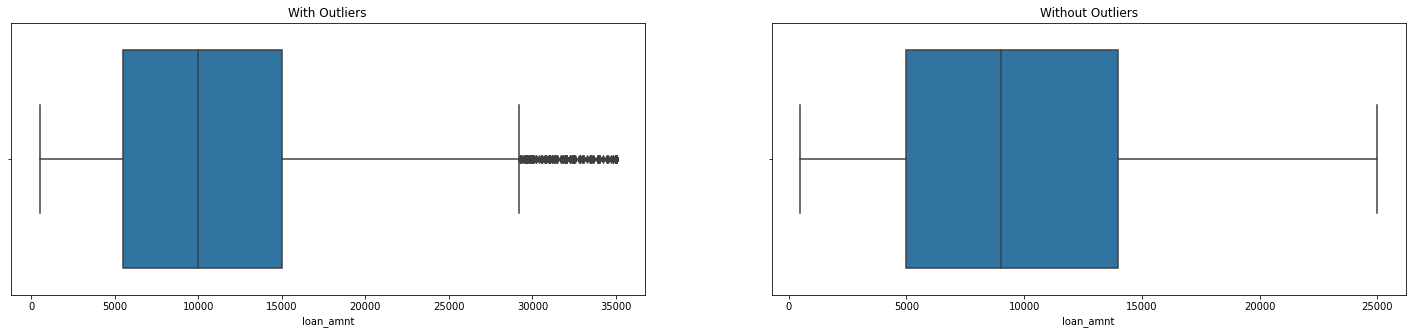

In [35]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.loan_amnt,ax=axes[0])
sns.boxplot(df[df.loan_amnt<25000].loan_amnt,ax=axes[1])



<AxesSubplot:title={'center':'Without Outliers'}, xlabel='int_rate'>

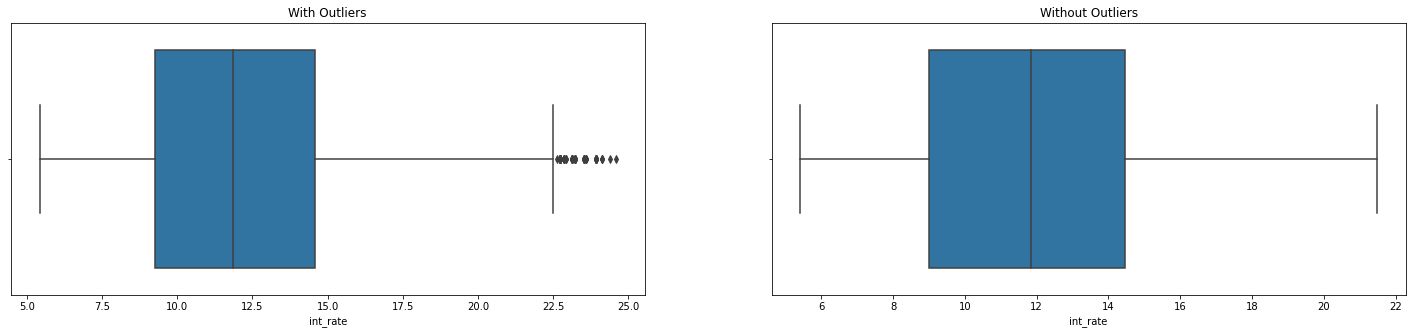

In [36]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.int_rate,ax=axes[0])
sns.boxplot(df[df.int_rate<21.5].int_rate,ax=axes[1])


<AxesSubplot:title={'center':'Without Outliers'}, xlabel='installment'>

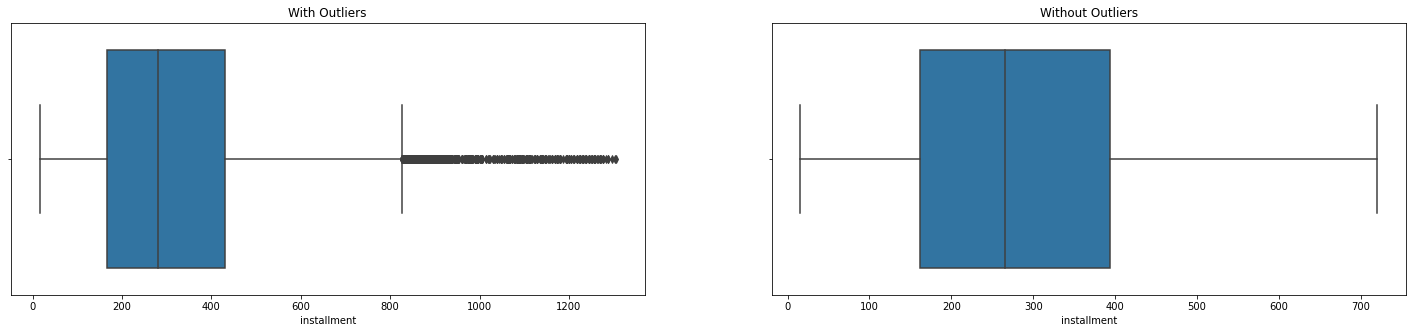

In [37]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.installment,ax=axes[0])
sns.boxplot(df[df['installment']<720].installment,ax=axes[1])

<AxesSubplot:title={'center':'Without Outliers'}, xlabel='funded_amnt_inv'>

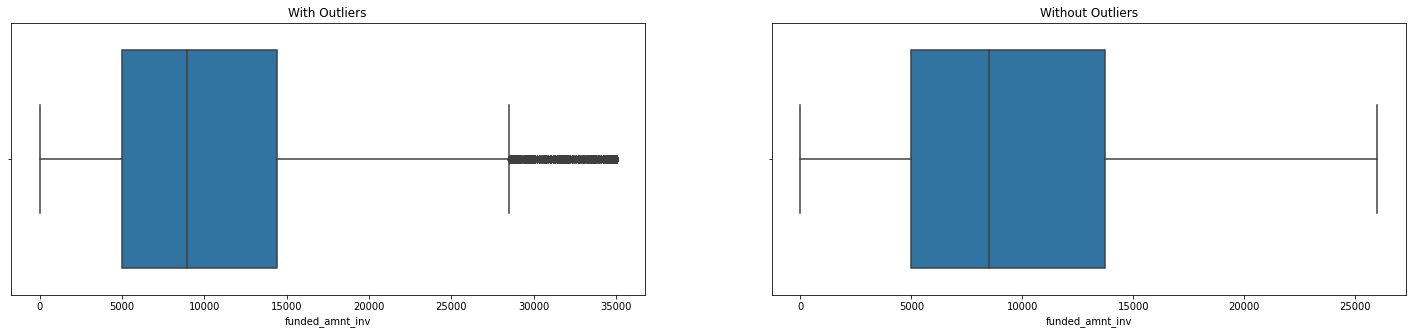

In [38]:
fig,axes=plt.subplots(1,2,figsize=(25,5))
axes[0].set_title('With Outliers')
axes[1].set_title('Without Outliers')
sns.boxplot(df.funded_amnt_inv,ax=axes[0])
sns.boxplot(df[df.funded_amnt_inv<26000].funded_amnt_inv,ax=axes[1])

# EDA - START

## Univariate Analysis

In [39]:
# changing the loan_status to a numeric variable, assign 1 for defaulted loans and 0 for paid off ones
df['loan_status_num'] = df['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0)

In [40]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,total_acc,initial_list_status,out_prncp,recoveries,collection_recovery_fee,application_type,pub_rec_bankruptcies,issue_y,issue_m,loan_status_num
0,5000,5000,4975.0,3,10.65,162.87,B,B2,Other,10,...,9,f,0.00,0.00,0.00,INDIVIDUAL,0.0,11,Dec,0
1,2500,2500,2500.0,5,15.27,59.83,C,C4,Ryder,0,...,4,f,0.00,117.08,1.11,INDIVIDUAL,0.0,11,Dec,1
2,2400,2400,2400.0,3,15.96,84.33,C,C5,Other,10,...,10,f,0.00,0.00,0.00,INDIVIDUAL,0.0,11,Dec,0
3,10000,10000,10000.0,3,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,...,37,f,0.00,0.00,0.00,INDIVIDUAL,0.0,11,Dec,0
4,3000,3000,3000.0,5,12.69,67.79,B,B5,University Medical Group,1,...,38,f,524.06,0.00,0.00,INDIVIDUAL,0.0,11,Dec,0


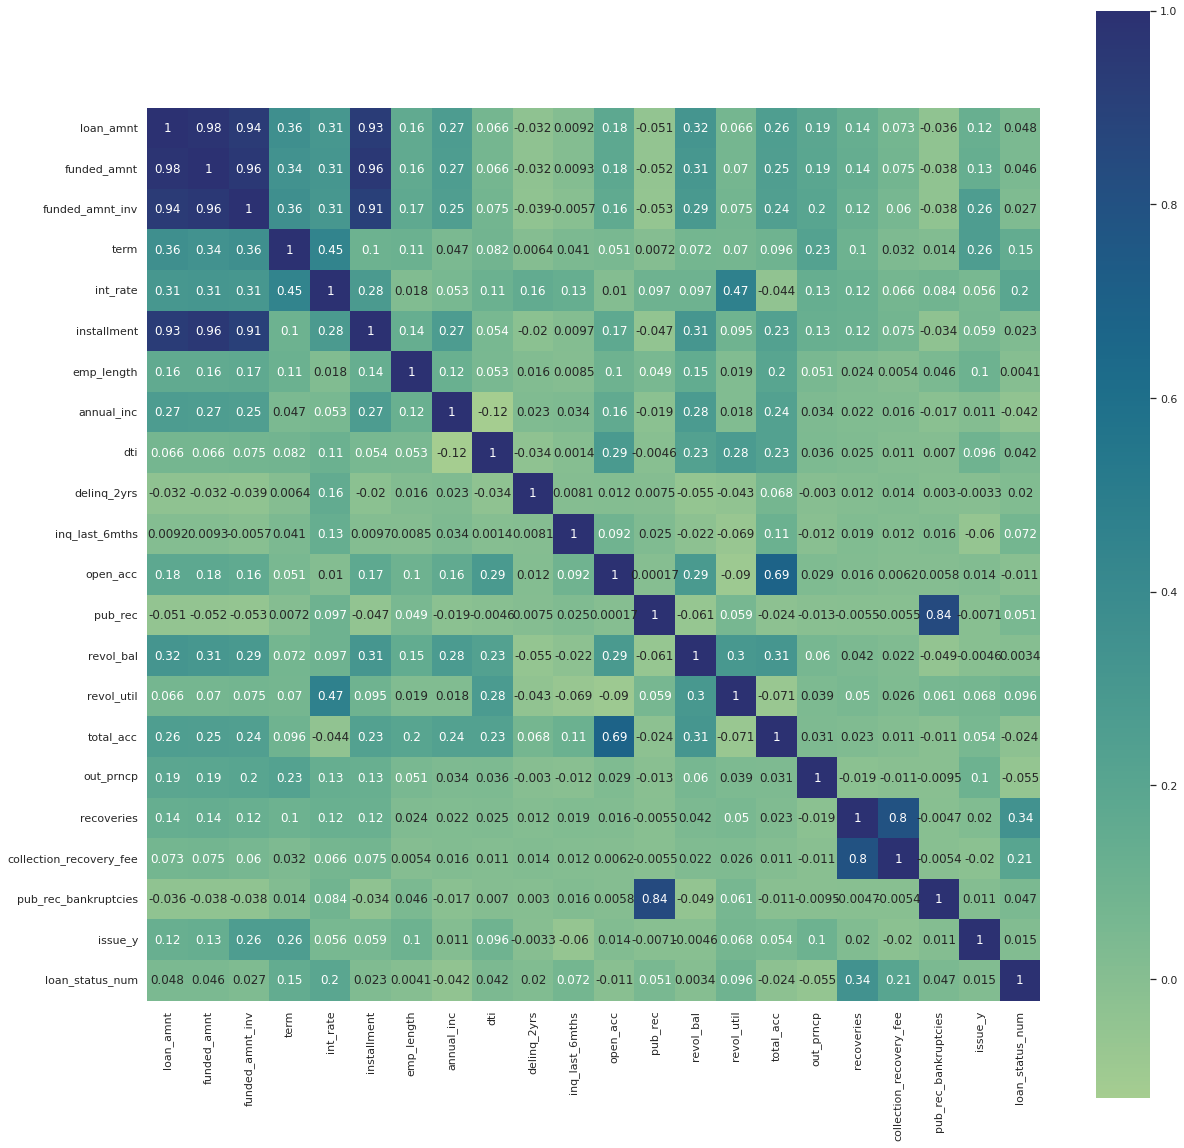

In [41]:

sns.set(rc = {'figure.figsize':(20,20)})
sns.heatmap(data=df.corr(),square=True,annot=True,cmap="crest")

plt.show()

### Observation from above Plot: 

From the plot, we can observe the correlation between the fields.
It is clearly visible that loan_amnt, funded_amnt, funded_amnt_inv and installment have high correlation.
The public records related fields pub_rec & pub_rec_bankrupcies and number of accounts related fields open_acc & total_acc are correlated.
